# Modelamiento de Tópicos Mediante Asignación Latente de Dirichlet

<img style="float: right; margin: 0px 0px 15px 15px;" src="https://upload.wikimedia.org/wikipedia/commons/4/4d/Wikipedia_15_-_Twitter_wordcloud.png" width="500px" height="300px" />

> En este notebook veremos un modelo muy poderoso para modelar documentos de texto de acuerdo a las proporciones de diferentes tópicos que contiene. Esta técnica es bastante poderosa, y sirve para:
> 1. Representar documentos en vectores de tópicos.
> 2. Identificar documentos con tópicos similares.
> 3. Hacer clustering de documentos.
> 
> Entre otros.

> **Objetivos:**
> - Entender qué es modelamiento de tópicos.
> - Definir la distribución de Dirichlet.
> - Entender la asignación latente de Dirichlet como un modelo generativo de texto.

> **Referencias:**
> - Bayesian Methods for Machine Learning course, HSE University, Coursera.

## 1. Modelamiento de tópicos

Para entender qué es modelamiento de tópicos, veámoslo con un ejemplo.

Supongamos que queremos construir un sistema de recomendación, el cual a partir de libros que ya has leido, te recomienda **libros de tópcios similares**.

En este sentido, quisiéramos extraer los tópicos o temas del libro. Por ejemplo:

<img style="float: right; margin: 0px 0px 15px 15px;" src="https://images-na.ssl-images-amazon.com/images/I/41TmbdP0EZL._SX331_BO1,204,203,200_.jpg" width="200px" height="100px" />

> - Statistics: 40%

> - Machine Learning: 40%

> - R: 20%

<img style="float: right; margin: 0px 0px 15px 15px;" src="https://images-na.ssl-images-amazon.com/images/I/61GPrIQcOvL._SY264_BO1,204,203,200_QL40_ML2_.jpg" width="200px" height="100px" />

> - Statistics: 40%

> - Machine Learning: 60%

> - R: 0%

De esta manera, podemos interpretar lo siguiente:

> Un **documento** es una distribución sobre tópicos.

¿Y qué son los **tópicos**?

Si hablamos de un tópico en particular nos encotraremos que algunas palabras son muchísimo más frecuentes que otras, por ejemplo:

| Statistics            | Machine Learning         | R                   |
| --------------------- | ------------------------ | ------------------- |
| 20% Random Variables  | 10% Supervised           | 15% Programming     |
| 10% Distributions     | 8% Unsupervised          | 10% Data            |
| 10% Bayes             | 5% Overfitting           | 5% Functions        |
| 2% Hypothesis         | 3% Hyperparameters       | 5% Model            |
| ...                   | ...                      | ...                 |

Por tanto:

> Un **tópico** es una distribución sobre palabras.

Usando los tópicos podemos construir el texto:

- We can use the $\underbrace{\text{Bayes}}_{\text{Statistics}}$ theorem to construct both $\underbrace{\text{supervised}}_{\text{Machine Learning}}$ and $\underbrace{\text{unsupervised}}_{\text{Machine Learning}}$ $\underbrace{\text{models}}_{\text{R}}$.

Teniendo esto claro, volvamos a nuestro ejemplo de sistema de recomendación.

**¿Cómo podemos evaluar que un libro se parece a otro?**

<img style="float: right; margin: 0px 0px 15px 15px;" src="https://images-na.ssl-images-amazon.com/images/I/41TmbdP0EZL._SX331_BO1,204,203,200_.jpg" width="200px" height="100px" />

> - Statistics: 40%

> - Machine Learning: 40%

> - R: 20%

Así:

$$x = \left[\begin{array}{c} 0.4 \\ 0.4 \\ 0.2 \end{array}\right]$$

<img style="float: right; margin: 0px 0px 15px 15px;" src="https://images-na.ssl-images-amazon.com/images/I/61GPrIQcOvL._SY264_BO1,204,203,200_QL40_ML2_.jpg" width="200px" height="100px" />

> - Statistics: 40%

> - Machine Learning: 60%

> - R: 0%

Así:

$$y = \left[\begin{array}{c} 0.4 \\ 0.6 \\ 0.0 \end{array}\right]$$

Una vez que tenemos la representación numérica de estos documentos, podemos calcular alguna medida de similaridad entre ambos:

1. Distancia Euclidiana:

   $$
   ||x - y||_2 = \sqrt{\sum_i (x_i - y_i)^2} \approx 0.2828
   $$
   
   - Mientras más cercano a cero, más parecidos.
   
2. Similaridad de coseno:

   $$
   \cos(x, y) = \frac{x^T y}{||x|| \cdot ||y||} \approx 0.9245
   $$
   
   - Mientras más cercano a uno, más parecidos.

Entonces, tenemos dos objetivos principales:

1. Construir los tópicos de manera automática (no supervisado). No tendremos etiquetas de los tópicos, pero podremos inferirlos revisando las palabras más relevantes.

| Statistics            | Machine Learning         | R                   |
| --------------------- | ------------------------ | ------------------- |
| 20% Random Variables  | 10% Supervised           | 15% Programming     |
| 10% Distributions     | 8% Unsupervised          | 10% Data            |
| 10% Bayes             | 5% Overfitting           | 5% Functions        |
| 2% Hypothesis         | 3% Hyperparameters       | 5% Model            |
| ...                   | ...                      | ...                 |

2. Asignar la distribución de tópicos a cada texto.

## 2. Distribución de Dirichlet

Antes de continuar con nuestro modelamiento de tópicos, veamos una distribución de probabilidad fundamental: **La Distribución de Dirichlet**.

La distribución de Dirichlet es una distribución continua (generalización de la **Distribución Beta**) y se define como sigue:

$$
\text{Dir}(\theta | \alpha) = \frac{1}{B(\alpha)} \prod_{k=1}^{K} \theta_k^{\alpha_k - 1},
$$

donde $\alpha = \left[\alpha_1 \quad \dots \quad \alpha_K\right]^T \in \mathbb{R}_{>0}^{K}$, y el soporte de la distribución es:

$$
0 < \theta_k < 1 \quad \forall k, \qquad \text{y} \qquad \sum_{k=1}^{K} \theta_k = 1.
$$

Además, 

$$
B(\alpha) = \frac{\prod_{k=1}^{K} \Gamma(\alpha_k)}{\Gamma\left(\sum_{k=1}^{K} \alpha_k\right)}.
$$

Es importante notar que la región descrita por:

$$
0 < \theta_k < 1 \quad \forall k, \qquad \text{y} \qquad \sum_{k=1}^{K} \theta_k = 1.
$$

se llama **símplex**. 

1. ¿Cómo luce un símplex para $K=2$? -> Distribución Beta
2. ¿Cómo luce un símplex para $K=3$?

![](https://upload.wikimedia.org/wikipedia/commons/5/54/LogDirichletDensity-alpha_0.3_to_alpha_2.0.gif)

Ilustración de cómo cambia el logaritmo de la función de densidad para $K=3$, variando el vector $\alpha$ de (0.3, 0.3, 0.3) a (2.0, 2.0, 2.0), manteniendo  los $\alpha_i$ iguales.

Tomado de: https://en.wikipedia.org/wiki/Dirichlet_distribution

El siguiente código fue tomado de:

http://blog.bogatron.net/blog/2014/02/02/visualizing-dirichlet-distributions/

In [1]:
# Importamos librerías
from matplotlib import pyplot as plt
from scipy.stats import dirichlet
from matplotlib import tri
import numpy as np

In [2]:
corners = np.array([[0, 0], [1, 0], [0.5, 0.75**0.5]])
AREA = 0.5 * 1 * 0.75**0.5
triangle = tri.Triangulation(corners[:, 0], corners[:, 1])

In [3]:
# For each corner of the triangle, the pair of other corners
pairs = [corners[np.roll(range(3), -i)[1:]] for i in range(3)]
# The area of the triangle formed by point xy and another pair or points
tri_area = lambda xy, pair: 0.5 * np.linalg.norm(np.cross(*(pair - xy)))

def xy2bc(xy):
    '''Converts 2D Cartesian coordinates to barycentric.'''
    coords = np.array([tri_area(xy, p) for p in pairs]) / AREA
    return np.clip(coords, 0, 1.0)

In [4]:
def draw_pdf_contours(X, nlevels=200, subdiv=6, **kwargs):
    import math

    refiner = tri.UniformTriRefiner(triangle)
    trimesh = refiner.refine_triangulation(subdiv=subdiv)
    pvals = [X.pdf(xy2bc(xy)) for xy in zip(trimesh.x, trimesh.y)]

    plt.tricontourf(trimesh, pvals, nlevels, cmap='jet', **kwargs)
    plt.axis('equal')
    plt.xlim(0, 1)
    plt.ylim(0, 0.75**0.5)
    plt.axis('off')

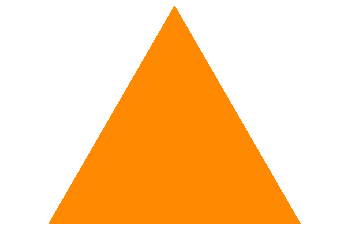

In [5]:
# Distribución Uniforme
draw_pdf_contours(dirichlet(alpha=[1, 1, 1]))

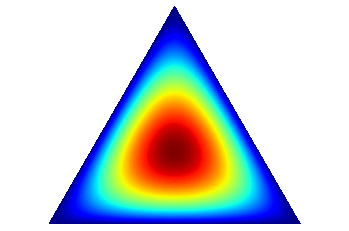

In [6]:
draw_pdf_contours(dirichlet(alpha=[2, 2, 2]))

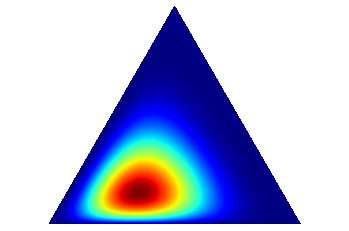

In [7]:
draw_pdf_contours(dirichlet(alpha=[5, 3, 2]))

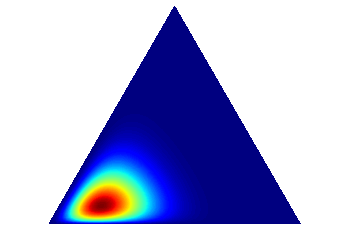

In [8]:
draw_pdf_contours(dirichlet(alpha=[10, 3, 2]))

Los parámetros $\alpha_k$ influyen directamente en la concentración de la densidad de la distribución en el símplex. Los que jugaban fútbol en play station deben recordar diagramas de este estilo cuyos vértices eran:

- Stamina
- Speed
- Strength
- Definition
- Pass
- ...

**Estadísticos importantes:**

Para la distribución de Dirichlet:

$$
\text{Dir}(\theta | \alpha) = \frac{1}{B(\alpha)} \prod_{k=1}^{K} \theta_k^{\alpha_k - 1},
$$

se tiene que $\left(\alpha_0 = \sum_{k=1}^{K} \alpha_k\right)$:

1. Media
  
   $$
   \mathbb{E}[\theta_k] = \frac{\alpha_k}{\alpha_0}
   $$
   
2. Moda
     
   $$
   \text{Mode}[\theta_k] = \frac{\alpha_k - 1}{\alpha_0 - K}
   $$

3. Varianza
   
   $$
   \text{Var}[\theta_k] = \frac{\alpha_k (\alpha_0 - \alpha_k)}{\alpha_0^2 (\alpha_0 + 1)}
   $$
   
4. Covarianza
   
   $$
   \text{Cov}[\theta_k, \theta_j] = \frac{- \alpha_k \alpha_j}{\alpha_0^2 (\alpha_0 + 1)}, \qquad \text{para } j\neq k
   $$

Entre muchas otras cosas, la distribución de Dirichlet es importante porque es la previa conjugada de una distribución multinomial.

**Ejemplo:**

Supongamos que Y es una VA que representa los tiros de un dado con diferentes probabilidades en cada cara:

$$
p(Y = i | \theta) = \theta_i,
$$

con $i=1,\dots, 6$, $\theta_i > 0$ y $\sum_i \theta_i = 1$.

Entonces, definiendo $N_i$ como el número de veces que el dado cayó en la cara $i$ en el conjunto de datos $X$, la funciónde verosimilitud es:

$$
p(X | \theta) = \theta_1^{N_1} \theta_2^{N_2} \dots \theta_6^{N_6} = \prod_{i=1}^{6} \theta_i^{N_i}
$$

De modo que, si modelamos la previa de las probabilidades $\theta$ como $p(\theta) = \text{Dir}(\theta | \alpha)$, tenemos que:

$$
p(\theta | X) \propto p(X | \theta) p(\theta) \propto \prod_{i=1}^{6} \theta_i^{N_i + \alpha_i - 1} = \text{Dir}(\theta | \alpha + N).
$$

## 3. Modelo de Asignación Latente de Dirichlet

Recordemos nuestro razonamiento inicial:

> Un documento es una distribución sobre tópicos.

> Un tópico es una distribución sobre palabras.

Estas ideas nos permiten recrear un modelo generativo para textos de la siguiente manera:

![](figures/text_model.png)

De esta manera el modelo es:


![](figures/lda.png)

Lo anterior se conoce como un modelo de plantilla. Tenemos:

- Una distribución documento-tópico $p(\theta_d)$ para cada documento $d$.
- Un tópico por cada palabra de cada documento, determinado por la distribución de documento $p(z_{dn} | \theta_d)$.
- Las palabras observadas (datos) dadas por $p(x_{dn} | z_{dn})$.

Con lo anterior, la probabilidad conjunta de documentos, tópicos y palabras es:

$$
p(\Theta, Z, X) = \prod_{d=1}^{D} p(\theta_d) \prod_{n=1}^{N_d} p(z_{dn} | \theta_d) p(x_{dn} | z_{dn})
$$

**Importante.** Este modelo no considera el orden de las palabras.

Ahora, ¿Cómo modelamos las anteriores distribuciones?

- $p(\theta_d) = \text{Dir}(\theta | \alpha)$: Una distribución de Dirichlet donde el $t-$ésimo componente de $\theta_{d t}$ representa la proporción del tópico $t$ en el documento d.
- $p(z_{dn} | \theta_d) = \theta_{d z_{dn}}$
- $p(x_{dn} | z_{dn}) = \phi_{z_{dn} x_{dn}}$

Las probabilidades de las palabras $x$ en el tópico $z$ las guardamos en la matriz $\Phi \in \mathbb{R}^{T \times W}$ ($T$ es el número de tópicos, y $W$ el número de palabras total en nuestro vocabulario). Por tanto las componentes de la matriz $\Phi$ deben satisfacer:

- $\phi_{tx} \geq 0, \quad \forall t, x$.
- $\sum_{x} \phi_{tx} = 1, \quad \forall t$

De modo que las variables en nuestro modelo son:

1. $X$: palabras, datos -> **Observadas**.

2. $\Phi$: parámetros, distribución tópico-palabras -> **Desconocidos**.

3. $Z$: variables latentes, tópico de cada palabra -> **Desconocidas**.

4. $\Theta$: variables latentes, distribución documento-tópicos -> **Desconocidas**.

<script>
  $(document).ready(function(){
    $('div.prompt').hide();
    $('div.back-to-top').hide();
    $('nav#menubar').hide();
    $('.breadcrumb').hide();
    $('.hidden-print').hide();
  });
</script>

<footer id="attribution" style="float:right; color:#808080; background:#fff;">
Created with Jupyter by Esteban Jiménez Rodríguez.
</footer>